In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
def plot_grade_distributions(df, y_cols, ends_only_xticks=False):
  _, axes = plt.subplots(1, 3, figsize=(18, 5))
  for ax, col in zip(axes, y_cols):
          sns.countplot(data=df, x=col, ax=ax, palette='pastel', hue=col, legend=False)
          ax.set_title(col.capitalize())
          ax.set_xlabel('')
          ax.set_ylabel('')
          
          if ends_only_xticks:
            labels = [t.get_text() for t in ax.get_xticklabels()]
            if len(labels) >= 2:
                ax.set_xticks([0, len(labels) - 1])
                ax.set_xticklabels([labels[0], labels[-1]])
  plt.tight_layout()
  plt.show()
  
  
  
def plot_correlation_heatmap(df, y_cols):
  corr = df[y_cols].corr()
  plt.figure(figsize=(6, 5))
  sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
        linewidths=0.5, cbar_kws={'shrink': 0.8})
  plt.title('Correlation between criteria')
  plt.xticks(rotation=45, ha='right')
  plt.yticks(rotation=0)
  plt.tight_layout()
  plt.show()
  return corr

# Conservative Unicode normalization for essays (hardcoded replacements, overwrite original columns)
import unicodedata
import re
import html as _html

# mapping for conservative replacements (hardcoded)
replacements = {
    '\u00A0': ' ',      # NBSP
    '\u2002': ' ',      # en space
    '\u2003': ' ',      # em space
    '\u2018': "'",    # left single smart quote
    '\u2019': "'",    # right single smart quote
    '\u201C': '"',    # left double smart quote
    '\u201D': '"',    # right double smart quote
    '\u2013': '-',     # en dash
    '\u2014': '-',     # em dash
    '\u2026': '...',   # ellipsis
    '\ufb01': 'fi',    # ligatures
    '\ufb02': 'fl',
    '\ufb00': 'ff',
    '\ufb03': 'ffi',
    '\ufb04': 'ffl',
    '\u200B': '',      # zero-width
    '\u200C': '',
    '\u200D': '',
    '\uFEFF': ''
}
# control chars (except newline/tab/carriage return)
for code in list(range(0,32)) + list(range(127,160)):
    ch = chr(code)
    if ch in ('\n', '\t', '\r'):
        continue
    replacements.setdefault(ch, '')

rep_pattern = re.compile('|'.join(re.escape(k) for k in sorted(replacements, key=len, reverse=True))) if replacements else None

# HTML handling helpers (preserve inner text)
_br_re = re.compile(r'(?i)<br\s*/?>')
_p_open_re = re.compile(r'(?i)<p\b[^>]*>')
_p_close_re = re.compile(r'(?i)</p>')
_a_re = re.compile(r'(?i)<a\b[^>]*href=["\']([^"\']+)["\'][^>]*>(.*?)</a>', flags=re.S)
_tag_re = re.compile(r'<[^>]+>')
_korean_re = re.compile(r'[\u1100-\u11FF\u3130-\u318F\uAC00-\uD7AF]+')
  
  
  
def normalise_text(df):

  def handle_html(text: str) -> str:
      if not isinstance(text, str):
          return text
      text = _html.unescape(text)
      text = _br_re.sub('\n', text)
      text = _p_open_re.sub('\n\n', text)
      text = _p_close_re.sub('\n\n', text)

      def _a_repl(m):
          href = m.group(1).strip()
          inner = m.group(2).strip()
          if inner:
              return f"{inner} ({href})"
          return href
      text = _a_re.sub(_a_repl, text)

      text = _tag_re.sub('', text)
      return text

  def conservative_normalize(text: str) -> str:
      if not isinstance(text, str):
          return text
      text = handle_html(text)
      text = unicodedata.normalize('NFKC', text)
      text = _korean_re.sub(' [UNK] ', text)
      if rep_pattern:
          text = rep_pattern.sub(lambda m: replacements[m.group(0)], text)
      text = re.sub(r"[ \t]+", ' ', text)
      text = re.sub(r"\n{3,}", '\n\n', text)
      text = '\n'.join([ln.strip() for ln in text.splitlines()])
      return text

  orig_essay = df['essay'].copy()
  orig_prompt = df['prompt'].copy()

  df['essay'] = df['essay'].apply(conservative_normalize)
  df['prompt'] = df['prompt'].apply(conservative_normalize)

  print('Essay rows changed:', int((orig_essay != df['essay']).sum()))
  print('Prompt rows changed:', int((orig_prompt != df['prompt']).sum()))

  return df
  


DATA_DIR_PATH = '../data/DREsS/'

def plot_token_length_distributions(tsv, caps):
    
    TOKENIZER_PATH = "../models/deberta-v3-large"
    TSV_PATH       = DATA_DIR_PATH + tsv
    PROMPT_COL     = "prompt"
    ESSAY_COL      = "essay"
    BATCH_SIZE     = 4096
    BINWIDTH       = 1 

    from transformers import AutoTokenizer

    df = pd.read_csv(TSV_PATH, sep="\t")

    tok = AutoTokenizer.from_pretrained(
        TOKENIZER_PATH, use_fast=True, local_files_only=True
    )

    def pair_lengths(tokenizer, prompts, essays, batch=BATCH_SIZE):
        out = []
        for i in range(0, len(prompts), batch):
            enc = tokenizer(
                prompts[i:i+batch].astype(str).tolist(),
                essays[i:i+batch].astype(str).tolist(),
                add_special_tokens=True,
                truncation=False,
                padding=False,
                return_length=True
            )
            out.extend(enc.get("length", [len(x) for x in enc["input_ids"]]))
        return np.asarray(out, dtype=np.int32)

    if "pair_tokens" not in df.columns:
        df["pair_tokens"] = pair_lengths(tok, df[PROMPT_COL], df[ESSAY_COL])

    stats = []
    for cap in caps:
        mean_tokens = df["pair_tokens"].mean()
        std_tokens = df["pair_tokens"].std()
        q_noloss = (df["pair_tokens"] <= cap).mean()                 
        pct_trunc = 100.0 * (1.0 - q_noloss)
        stats.append(dict(cap=cap, no_loss_q=q_noloss, truncated_pct=pct_trunc, mean_tokens=mean_tokens, std_tokens=std_tokens))
    stats_df = pd.DataFrame(stats)
    print(stats_df)

    max_x = max(df["pair_tokens"].max(), max(caps))
    fig, axes = plt.subplots(len(caps), 1, figsize=(10, len(caps)*3), sharex=True, sharey=True)
    if type(axes) is not np.ndarray:
        axes = [axes]
    for ax, cap in zip(axes, caps):
        sns.histplot(
            df["pair_tokens"],
            binrange=(0, max_x),
            binwidth=BINWIDTH,
            discrete=(BINWIDTH == 1),
            stat="count",
            ax=ax,
        )
        ax.axvline(cap, linestyle="--")
        ax.axvspan(cap, max_x, alpha=0.15)

        q = (df["pair_tokens"] <= cap).mean()
        trunc = 100 * (1 - q)
        ymax = ax.get_ylim()[1]
        ax.text(
            cap, ymax * 0.92,
            f"F({cap}) = {q:.3f}\nTruncated: {trunc:.1f}%",
            ha="left", va="top"
        )

        ax.set_title(f"Token count distribution — cap = {cap}")
        ax.set_xlabel("Tokens (prompt + essay, joint encoding)")
        ax.set_ylabel("Sample count")

    plt.tight_layout()
    plt.show()

# DREsS New

In [162]:
dress_new = pd.read_csv(DATA_DIR_PATH + 'DREsS_New.tsv', sep='\t', index_col=0)
dress_new.shape

(2279, 6)

In [163]:
dress_new.isna().sum()

prompt            0
essay           300
content           0
organization      0
language          0
total           167
dtype: int64

In [164]:
dress_new.drop(columns=['total'], inplace=True)
dress_new.dropna(inplace=True)
dress_new.shape

(1979, 5)

In [165]:
y_cols = dress_new.select_dtypes('number').columns

In [ ]:
dress_new.drop_duplicates(subset=['essay'], inplace=True)
dress_new.shape

(1971, 5)

In [167]:
# show rows where numeric columns are less than or equal to 0.5
dress_new.loc[dress_new[y_cols].le(.5).any(axis=1)]


,prompt,essay,content,organization,language
id,,,,,
636,Univeristy: Some people believe that universit...,I used to be a person like to do only what I a...,0.5,1.5,2.0
916,Tech: Some people say that computers have made...,"So far, I think computer makes our life much m...",0.5,0.5,2.5
926,Tech: Some people say that computers have made...,think computers made our lives more convenient...,0.5,1.0,2.5


id 636 dropped as genuinely off-topic, id 916, 926 manually regraded

In [168]:
dress_new.loc[[916,926], y_cols] = [[2,1,2], [1,1,2]]
dress_new = dress_new[dress_new[y_cols].ge(1).all(axis=1)]
dress_new.shape

(1970, 5)

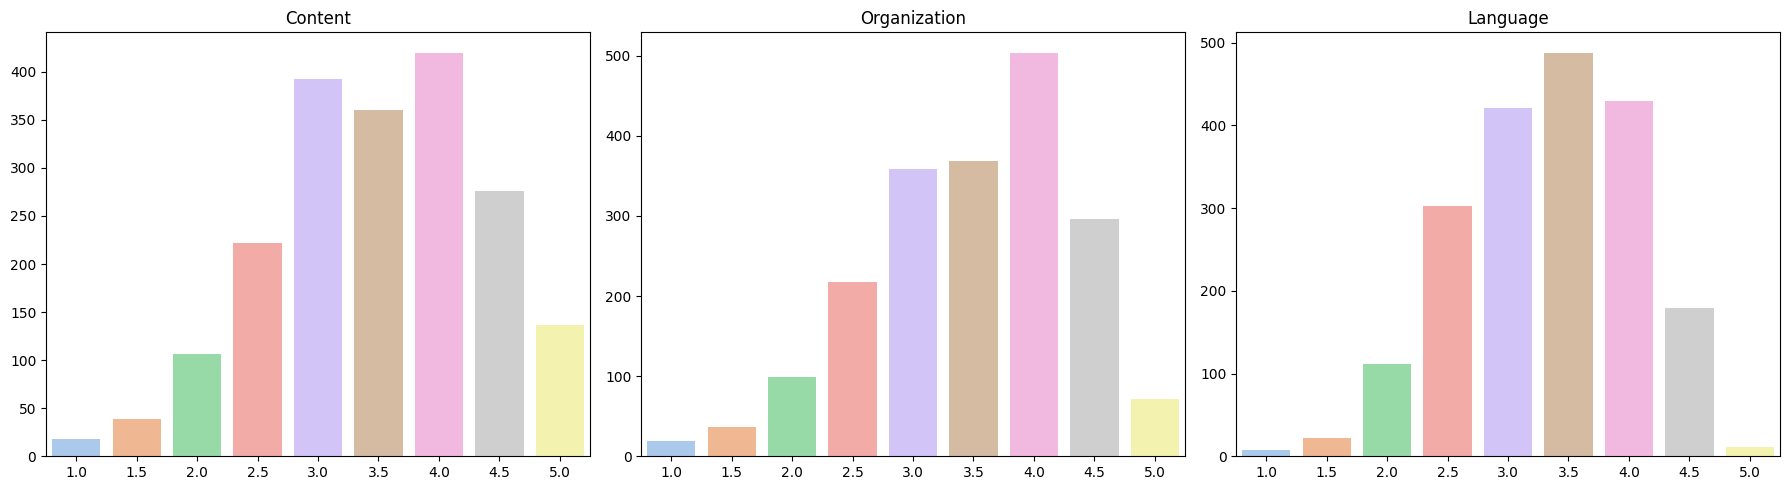

In [169]:
plot_grade_distributions(dress_new, y_cols)

*Score distributions of all three responses are left-skewed and highly imbalanced*

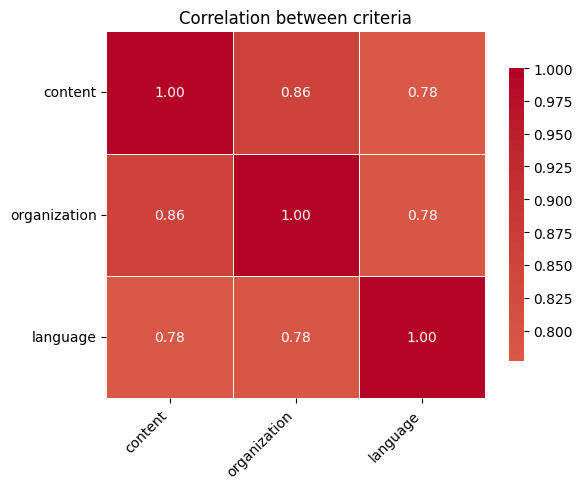

In [170]:
dress_new_corr_before = plot_correlation_heatmap(dress_new, y_cols)

*Content and organisation are very strongly related, while language use relates to each at a somewhat lower, yet strong level*

In [171]:
stats_skew = pd.DataFrame(columns=['before', 'after'], index=['dress_new_'+x for x in y_cols])
stats_skew.loc[:, 'before'] = dress_new[y_cols].skew().values

Floor all scores

In [172]:
dress_new[y_cols] = dress_new[y_cols].astype(int)

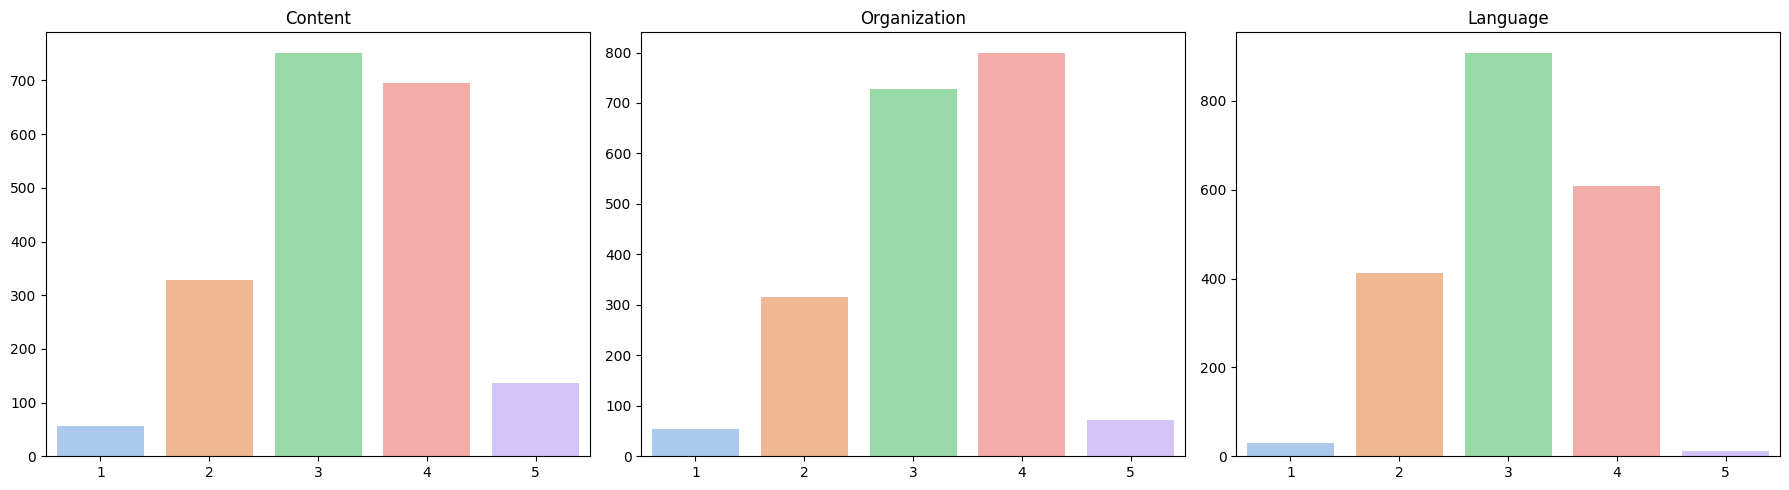

In [173]:
plot_grade_distributions(dress_new, y_cols)

In [174]:
stats_skew.loc[:, 'after'] = dress_new[y_cols].skew().values
stats_skew['change'] = stats_skew['after'] - stats_skew['before']
stats_skew

,before,after,change
dress_new_content,-0.309594,-0.239025,0.070568
dress_new_organization,-0.489078,-0.456232,0.032846
dress_new_language,-0.276371,-0.25909,0.017281


*Collapsing half-marks downward has centred the distributions to a minor degree, but the issue of imbalance remains.*

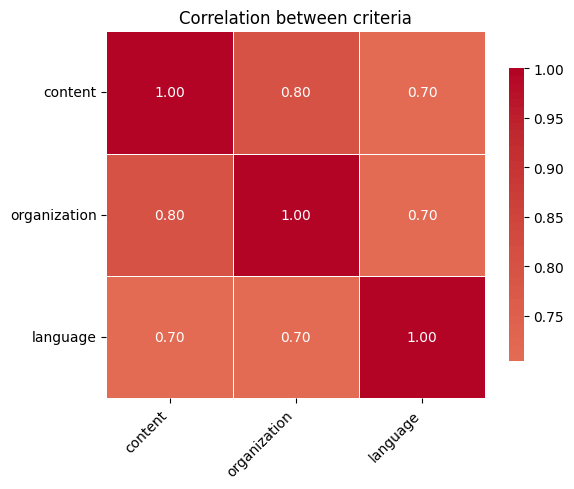

In [175]:
dress_new_corr_after = plot_correlation_heatmap(dress_new, y_cols)

In [176]:
dress_new_corr_after - dress_new_corr_before

,content,organization,language
content,0.000000,-0.059885,-0.072137
organization,-0.059885,0.000000,-0.080653
language,-0.072137,-0.080653,0.000000


*Pairwise correlations reduced by ~0.07*

#### Text normalization

In [177]:
dress_new = normalise_text(dress_new)

Essay rows changed: 1723
Prompt rows changed: 453


51

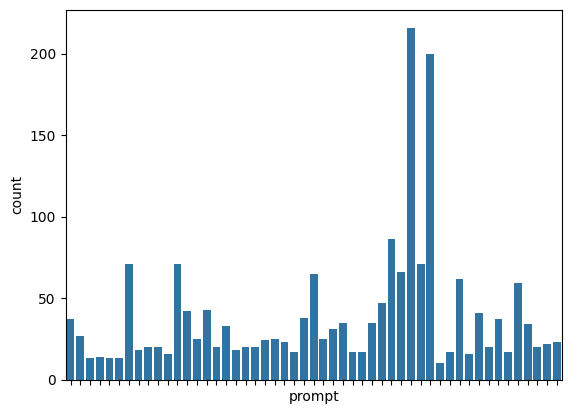

In [178]:
sns.countplot(data=dress_new, x='prompt')
ax = plt.gca()
ax.set_xlabel('prompt')
ax.tick_params(axis='x', labelbottom=False)
dress_new['prompt'].nunique()

In [179]:
# remove leading label-like prefixes (e.g. "University: ", "Lifestyle:") from prompt
orig = dress_new['prompt'].copy()
pattern = re.compile(r'^([A-Za-z&\'\-\(\)]+:\s*)')  # label up to colon at start
dress_new['prompt'] = dress_new['prompt'].astype(str).str.replace(pattern, '', regex=True).str.strip()
print('Prompts changed:', int((orig != dress_new['prompt']).sum()))

Prompts changed: 535


In [ ]:

unique_prompts = (
    dress_new.groupby('prompt', sort=False)
             .agg(
                 count=('prompt', 'size'),
                 ids=('prompt', lambda s: s.index.to_list())
             )
             .sort_values('count', ascending=False)
)

In [181]:
orig = dress_new['prompt'].copy()

for prompt, major_id in zip([
  "If you could change one important aspect about your country, what would you change? Give specific reasons and details to support your opinion.",
  "If you could change one important aspect about your university, what would you change? Give specific reasons and details to support your opinion.",
  "Some people believe that university students should be required to attend classes. Others believe that going to classes should be optional for students. Which point of view do you agree with? Use specific reasons and details to explain your answer. ?",
  "Some prefer to study alone. Others prefer to study with a group of students. Which do you prefer? Use specific reasons and examples to support your answer.",
  "Many students choose to attend schools or universities outside their home countries. Why do some students study abroad? Give specific reasons and details to support your opinion.",
  "Some people believe that a college or university education should be available to all students. Others believe that higher education should be available only to good students. Which view do you agree with? Use specific reasons and examples to support your answer"
],
[
  1261, 1401, 397, 433, 1791, 28
]
):
  dress_new.loc[unique_prompts.loc[prompt, 'ids'], 'prompt'] = dress_new.loc[major_id, 'prompt']
  
print('Prompts changed:', int((orig != dress_new['prompt']).sum()))

Prompts changed: 141


36

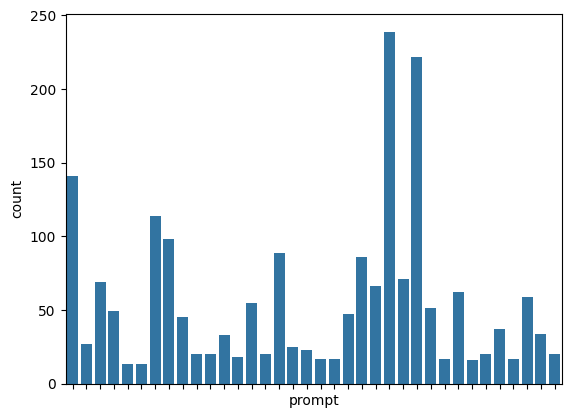

In [182]:
sns.countplot(data=dress_new, x='prompt')
ax = plt.gca()
ax.set_xlabel('prompt')
ax.tick_params(axis='x', labelbottom=False)
dress_new['prompt'].nunique()

In [ ]:
dress_new.to_csv(DATA_DIR_PATH + 'DREsS_New_cleaned.tsv', sep='\t', index=False)
print(f"Wrote {DATA_DIR_PATH + 'DREsS_New_cleaned.tsv'}")

Wrote ../data/DREsS/DREsS_New_cleaned.tsv


In [184]:
dress_new.describe()

,content,organization,language
count,1970.000000,1970.000000,1970.000000
mean,3.268020,3.262944,3.080711
std,0.917768,0.869258,0.770246
min,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000
50%,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000


   cap  no_loss_q  truncated_pct  mean_tokens  std_tokens
0  512   0.852284      14.771574   400.329949  109.792781
1  640   0.975635       2.436548   400.329949  109.792781
2  808   0.998985       0.101523   400.329949  109.792781


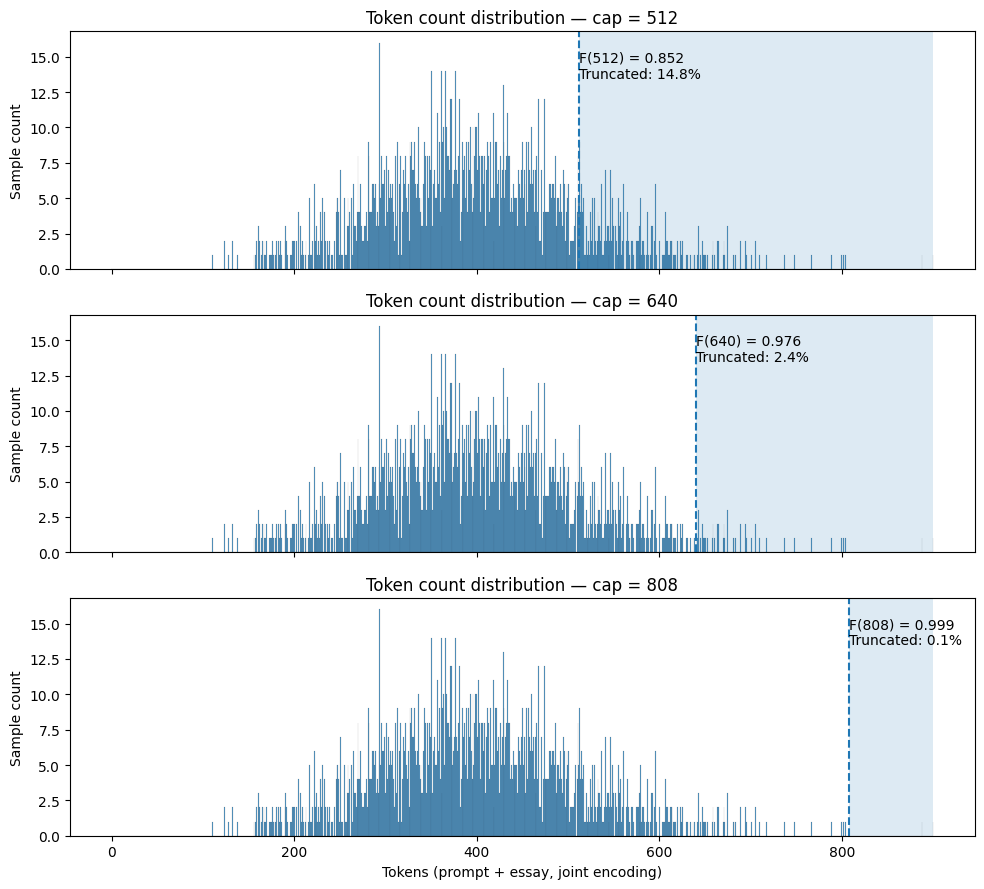

In [188]:
plot_token_length_distributions('DREsS_New_cleaned.tsv', (512, 640, 808))

# DREsS Std


Processing ../data/DREsS/DREsS_Std.tsv
  initial shape: (6508, 7)


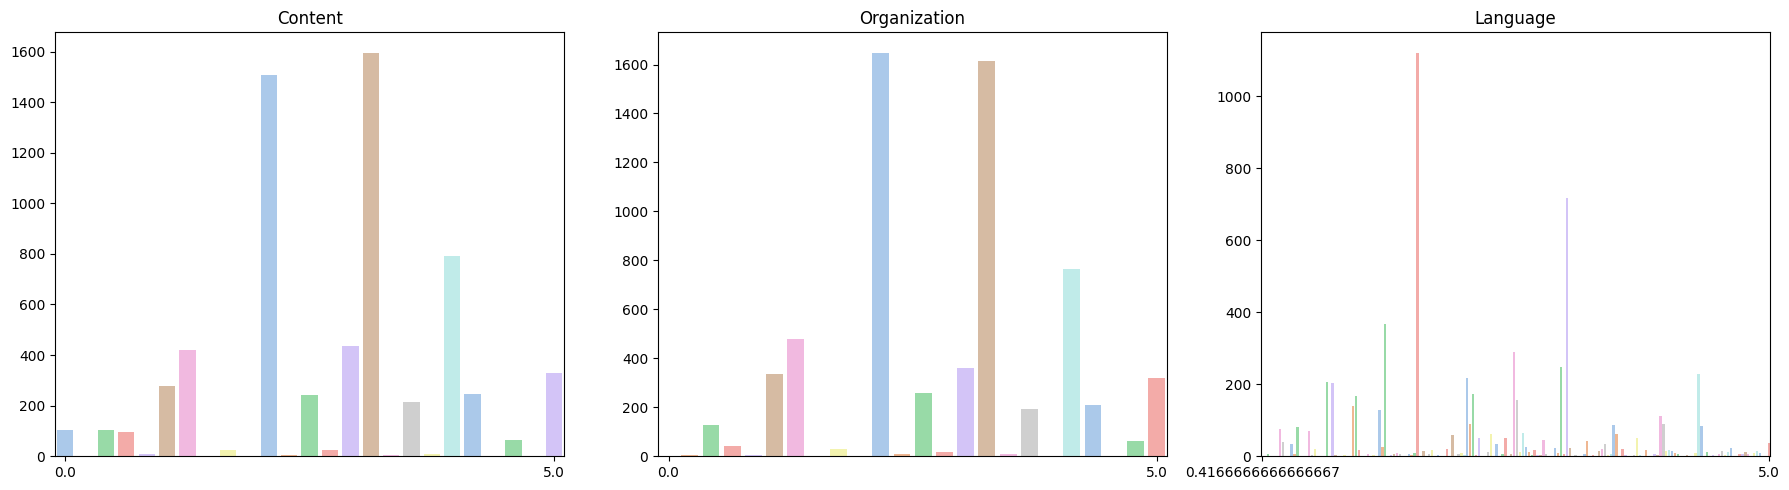

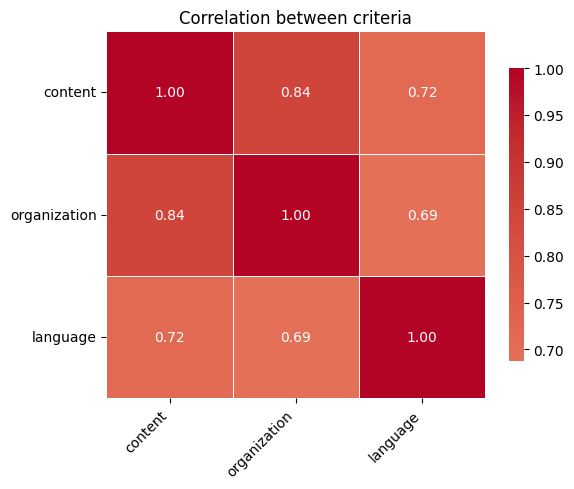

(109, 6)
  after cleaning shape: (6399, 6)
Essay rows changed: 3479
Prompt rows changed: 723
Wrote ../data/DREsS/DREsS_Std_cleaned.tsv


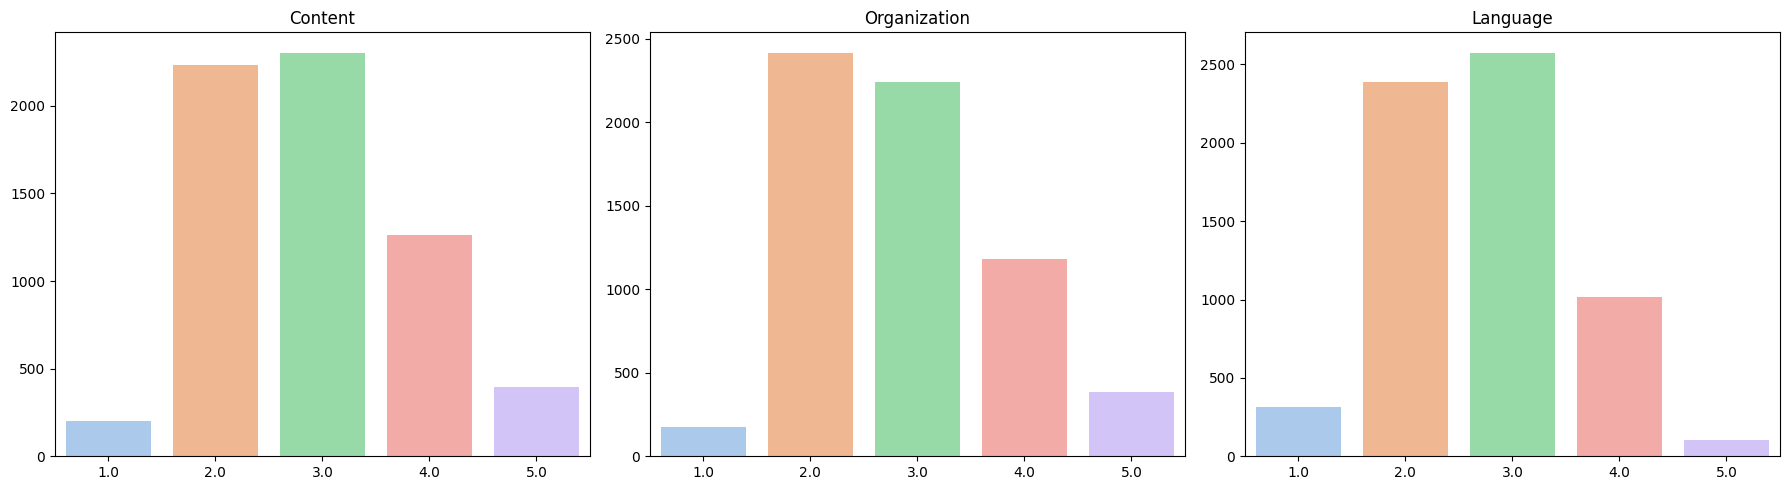

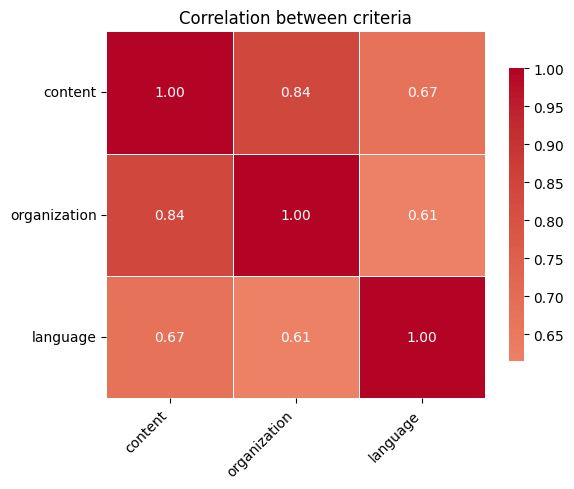

   cap  no_loss_q  truncated_pct
0  808   0.885763       11.42366


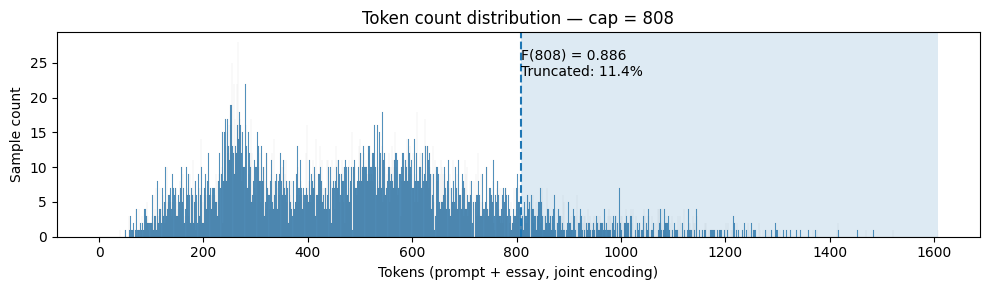

In [ ]:
fp = DATA_DIR_PATH + 'DREsS_Std.tsv'

print('\nProcessing', fp)
try:
    df = pd.read_csv(fp, sep='\t', index_col=0)
except Exception as e:
    print('  (read with index_col=0 failed:', e, ') -- retrying without index')
    df = pd.read_csv(fp, sep='\t')
print('  initial shape:', df.shape)

df.describe(include='all').T

df.drop(columns=['total'], inplace=True, errors='ignore')

df.dropna(subset=['essay'], inplace=True)
df.drop_duplicates(subset=['essay'], inplace=True)

plot_grade_distributions(df, y_cols, True)
plot_correlation_heatmap(df, y_cols)


print(df.loc[df[y_cols].le(0.5).any(axis=1)].shape)
df[y_cols] = df[y_cols].round()
df.drop(index=df.loc[df[y_cols].eq(0).any(axis=1)].index, inplace=True)
print('  after cleaning shape:', df.shape)

normalise_text(df, fp.replace('.tsv', '_cleaned.tsv'))

plot_grade_distributions(df, y_cols)
plot_correlation_heatmap(df, y_cols)

plot_token_length_distributions('DREsS_Std_cleaned.tsv', (808,))

# DREsS CASE
--- for future experiments

In [ ]:
cases = [DATA_DIR_PATH + 'DREsS_CASE_' + y_col + '.tsv' for y_col in y_cols]
for fp in cases:
    print('\nProcessing', fp)
    try:
        df = pd.read_csv(fp, sep='\t', index_col=0)
    except Exception as e:
        print('  (read with index_col=0 failed:', e, ') -- retrying without index')
        df = pd.read_csv(fp, sep='\t')
    print('  initial shape:', df.shape)

    df.drop(columns=['total'], inplace=True, errors='ignore')

    df.dropna(subset=['essay'], inplace=True)
    df.drop_duplicates(subset=['essay'], inplace=True)

    y_cols = df.select_dtypes('number').columns.tolist()
    df[y_cols] = df[y_cols].astype(int)
    df.drop(index=df.loc[df[y_cols].eq(0).any(axis=1)].index, inplace=True)
    print('  after cleaning shape:', df.shape)

    normalise_text(df, fp.replace('.tsv', '_cleaned.tsv'))



Processing ../data/DREsS/DREsS_CASE_content.tsv
  initial shape: (8307, 3)
  after cleaning shape: (8300, 3)
  essay rows changed: 5251
  prompt rows changed: 540
  wrote ../data/DREsS/DREsS_CASE_content_cleaned.tsv

Processing ../data/DREsS/DREsS_CASE_organization.tsv
  initial shape: (31086, 3)
  after cleaning shape: (28981, 3)
  essay rows changed: 13773
  prompt rows changed: 1731
  wrote ../data/DREsS/DREsS_CASE_organization_cleaned.tsv

Processing ../data/DREsS/DREsS_CASE_language.tsv
  initial shape: (792, 3)
  after cleaning shape: (792, 3)
  essay rows changed: 644
  prompt rows changed: 90
  wrote ../data/DREsS/DREsS_CASE_language_cleaned.tsv


In [ ]:
DREsS_CASE_content_cleaned, DREsS_CASE_organization_cleaned, DREsS_CASE_language_cleaned = (
  pd.read_csv(DATA_DIR_PATH + 'DREsS_CASE_' + y_col + '_cleaned.tsv', sep='\t', index_col=0)
     for y_col in y_cols
)

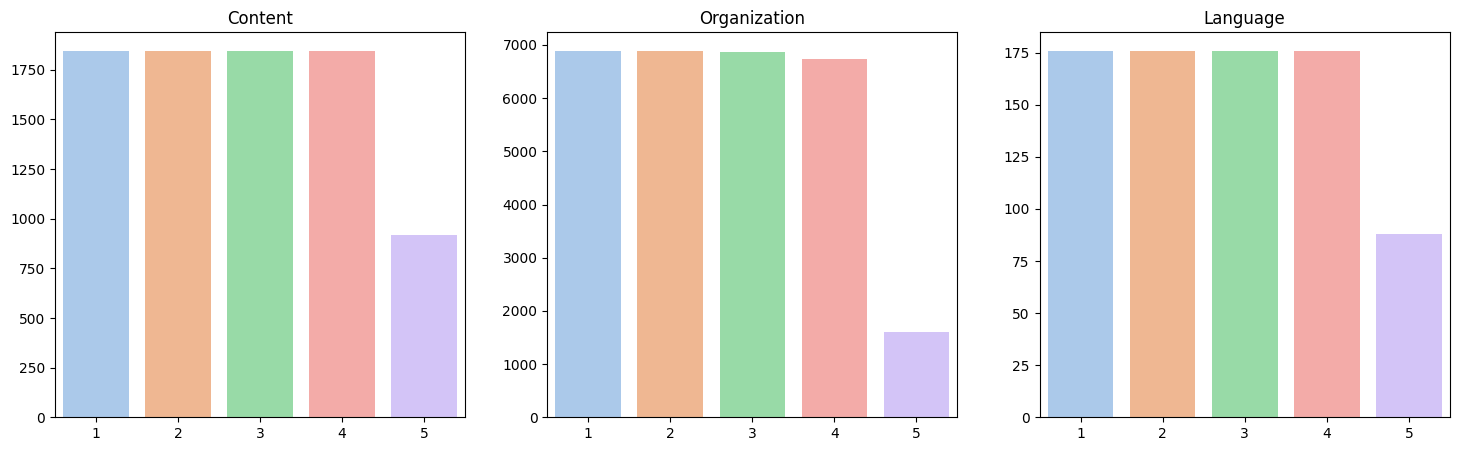

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for col, ds, ax in zip(
  y_cols,
  [DREsS_CASE_content_cleaned, DREsS_CASE_organization_cleaned, DREsS_CASE_language_cleaned],
  axes
  ):
  
  sns.countplot(data=ds, x=col, ax=ax, palette='pastel', legend=False, hue=col)
  ax.set_title(col.capitalize())
  ax.tick_params(axis='x')
  ax.set_ylabel('')
  ax.set_xlabel('')

plt.show()